# Raw Data

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("RawData") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .enableHiveSupport() \
    .getOrCreate()

24/08/05 19:06:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark.stop()

In [11]:
spark.sparkContext.getConf().getAll()

[('spark.sql.warehouse.dir', 'file:/home/lh/spark-warehouse'),
 ('spark.app.startTime', '1722863728957'),
 ('spark.hadoop.javax.jdo.option.ConnectionUserName', 'lh'),
 ('spark.app.id', 'app-20240805131532-0000'),
 ('spark.jars',
  '/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar'),
 ('spark.hadoop.javax.jdo.option.ConnectionURL',
  'jdbc:mysql://192.168.0.144:3306/metastore_db'),
 ('spark.app.submitTime', '1722863728538'),
 ('spark.repl.local.jars',
  'file:///usr/local/spark/jars/delta-storage-3.2.0.jar,file:///usr/local/spark/jars/delta-spark_2.12-3.2.0.jar'),
 ('spark.delta.logStore.class',
  'org.apache.spark.sql.delta.storage.HDFSLogStore'),
 ('spark.driver.memory', '19g'),
 ('spark.hadoop.javax.jdo.option.ConnectionPassword', 'Default_Value'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.cores', '3'),
 ('spark.driver.port', '41161'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'MyApp04'),
 ('spark

In [2]:
db='raw_data'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/raw_data'

In [3]:
#spark.sql(f"drop DATABASE {db} CASCADE")
#spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")
spark.sql(f"use database {db}")

DataFrame[]

In [4]:
# Check config
default_parallelism = spark.sparkContext.defaultParallelism
print(f"Default Parallelism: {default_parallelism}")
#spark.conf.set("spark.default.parallelism", "100")
shuffle_partitions = spark.conf.get("spark.sql.shuffle.partitions")
print(f"Shuffle Partitions: {shuffle_partitions}")
#spark.conf.set("spark.sql.shuffle.partitions", "100")

Default Parallelism: 15
Shuffle Partitions: 200


In [10]:
log_path = "hdfs://192.168.0.144:9000/spark/history"

event_log_df = spark.read.json(log_path)

event_log_df.printSchema()
event_log_df.show()

24/08/05 13:21:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- App ID: string (nullable = true)
 |-- App Name: string (nullable = true)
 |-- Block Manager ID: struct (nullable = true)
 |    |-- Executor ID: string (nullable = true)
 |    |-- Host: string (nullable = true)
 |    |-- Port: long (nullable = true)
 |-- Classpath Entries: struct (nullable = true)
 |    |-- /usr/local/spark/conf/: string (nullable = true)
 |    |-- /usr/local/spark/jars/HikariCP-2.5.1.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/JLargeArrays-1.5.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/JTransforms-3.1.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/RoaringBitmap-0.9.45.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/ST4-4.0.4.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/activation-1.1.1.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/aircompressor-0.26.jar: string (nullable = true)
 |    |-- /usr/local/spark/jars/algebra_2.12-2.0.1.jar: string (nullable = true)
 | 

+--------------------+----------+--------------------+--------------------+---------------+--------------------+-----------+--------------------+--------------------------+--------------------+--------------------+------+----------+--------------+----------------------+---------------------+--------------------+----------+--------------------+-------------------+--------------------+-------------+----------------+--------+---------+----------+-----------+---------------+--------------------+---------------+---------------------+---------+------------+----------------------+---------+-------------+----+------------+-----------+-------+------------+-----------+-------+---------------+-----------------------+---------------+-------------+----+
|              App ID|  App Name|    Block Manager ID|   Classpath Entries|Completion Time|               Event|Executor ID|       Executor Info|Executor Resource Requests|   Hadoop Properties|     JVM Information|Job ID|Job Result|Maximum Memory|Ma

In [26]:
# Print configuration details
print("Spark Version:", spark.sparkContext.version)
print("Master:", spark.sparkContext.master)
print("App Name:", spark.sparkContext.appName)
print("Spark Web UI:", spark.sparkContext.uiWebUrl)

print("Is Spark Context active?", not spark.sparkContext._jsc.sc().isStopped())

print("\nSpark Configuration Settings:")
for item in sorted(spark.sparkContext.getConf().getAll()):
    print(f"{item[0]}: {item[1]}")

print("\nExecutor Configuration:")
print("Executor Memory:", spark.conf.get("spark.executor.memory", "Not Set"))
print("Executor Cores:", spark.conf.get("spark.executor.cores", "Not Set"))
print("Executor Instances:", spark.conf.get("spark.executor.instances", "Not Set"))

print("Driver Memory:", spark.conf.get("spark.driver.memory", "Not Set"))
print("Driver Cores:", spark.conf.get("spark.driver.cores", "Not Set"))

print("\nSystem Properties:")
for prop in spark.sparkContext.getConf().getAll():
    if "memory" in prop[0] or "cores" in prop[0]:
        print(f"{prop[0]}: {prop[1]}")

print("\nHive-related Spark Configuration:")
for k, v in spark.sparkContext.getConf().getAll():
    if "hive" in k:
        print(f"{k}: {v}")

print("\nHive Databases:")
spark.sql("SHOW DATABASES").show(truncate=False)

print("\nDetails of 'default' Database:")
spark.sql("DESCRIBE DATABASE EXTENDED default").show(truncate=False)

print("\nTables in default Database:")
spark.sql("SHOW TABLES IN default").show()

Spark Version: 3.5.1
Master: spark://192.168.0.144:7077
App Name: MyApp04
Spark Web UI: http://lh:4040
Is Spark Context active? True

Spark Configuration Settings:
spark.app.id: app-20240729150139-0001
spark.app.initial.jar.urls: spark://lh:40405/jars/delta-spark_2.12-3.2.0.jar,spark://lh:40405/jars/delta-storage-3.2.0.jar
spark.app.name: MyApp04
spark.app.startTime: 1722265299187
spark.app.submitTime: 1722265228321
spark.databricks.delta.clusteredTable.enableClusteringTablePreview: true
spark.delta.logStore.class: org.apache.spark.sql.delta.storage.HDFSLogStore
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens

In [12]:
print("Databases:")
spark.sql("SHOW DATABASES").show()
spark.sql("USE raw_data")
print("Tables in 'raw_data' database:")
spark.sql("SHOW TABLES").show(truncate=False)
spark.sql("DESCRIBE DETAIL raw_data_2").show(truncate=False)
spark.sql("DESCRIBE TABLE raw_data_2").show(truncate=False)

Databases:
+----------------+
|       namespace|
+----------------+
|      compaction|
|         default|
|liquidclustering|
|       partition|
|        raw_data|
|          stream|
|          zorder|
+----------------+

Tables in 'raw_data' database:
+---------+--------------+-----------+
|namespace|tableName     |isTemporary|
+---------+--------------+-----------+
|raw_data |campaign_dim  |false      |
|raw_data |customer_dim  |false      |
|raw_data |department_dim|false      |
|raw_data |location_dim  |false      |
|raw_data |product_dim   |false      |
|raw_data |raw_data_2    |false      |
|raw_data |raw_data_4    |false      |
|raw_data |raw_data_8    |false      |
|raw_data |rawdata_2     |false      |
|raw_data |rawdata_4     |false      |
|raw_data |rawdata_8     |false      |
+---------+--------------+-----------+



+------+------------------------------------+---------------------------------+-----------+------------------------------------------------------+----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                             |description|location                                              |createdAt             |lastModified           |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+---------------------------------+-----------+------------------------------------------------------+----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |ca00d492-cf92-40e9-80ee-6a159e88

In [5]:
# Create dimension tables

tables = [
    {
        "name": "product_dim",
        "columns": """
            product_id INT,
            product_name STRING,
            product_category STRING,
            product_price DOUBLE
        """
    },
    {
        "name": "location_dim",
        "columns": """
            location_id INT,
            location_name STRING,
            city STRING,
            state STRING,
            country STRING
        """
    },
    {
        "name": "department_dim",
        "columns": """
            department_id INT,
            department_name STRING,
            department_head STRING
        """
    },
    {
        "name": "campaign_dim",
        "columns": """
            campaign_id INT,
            campaign_name STRING,
            start_date DATE,
            end_date DATE
        """
    },
    {
        "name": "customer_dim",
        "columns": """
            customer_id INT,
            customer_name STRING,
            customer_email STRING,
            customer_segment STRING
        """
    }
]

for table in tables:
    spark.sql(f"""
    CREATE TABLE {table['name']} (
        {table['columns']}
    )
    USING delta;
    """)

24/07/31 16:31:18 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`product_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/31 16:31:18 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/07/31 16:31:20 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`location_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/31 16:31:23 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`department_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/31 16:31:24 WARN 

In [6]:
# Fill dimension tables with data
data = {
    "product_dim": [
        (1, 'Product A', 'Category 1', 19.99),
        (2, 'Product B', 'Category 2', 29.99),
        (3, 'Product C', 'Category 1', 39.99),
        (4, 'Product D', 'Category 3', 49.99),
        (5, 'Product E', 'Category 2', 59.99),
        (6, 'Product F', 'Category 4', 69.99),
        (7, 'Product G', 'Category 1', 79.99),
        (8, 'Product H', 'Category 5', 89.99),
        (9, 'Product I', 'Category 3', 99.99),
        (10, 'Product J', 'Category 2', 109.99)
    ],
    "location_dim": [
        (1, 'Location A', 'New York', 'NY', 'USA'),
        (2, 'Location B', 'Los Angeles', 'CA', 'USA'),
        (3, 'Location C', 'Chicago', 'IL', 'USA'),
        (4, 'Location D', 'Houston', 'TX', 'USA'),
        (5, 'Location E', 'Phoenix', 'AZ', 'USA'),
        (6, 'Location F', 'Philadelphia', 'PA', 'USA'),
        (7, 'Location G', 'San Antonio', 'TX', 'USA'),
        (8, 'Location H', 'San Diego', 'CA', 'USA'),
        (9, 'Location I', 'Dallas', 'TX', 'USA'),
        (10, 'Location J', 'San Jose', 'CA', 'USA')
    ],
    "department_dim": [
        (1, 'Sales', 'Alice Smith'),
        (2, 'Marketing', 'Bob Jones'),
        (3, 'Engineering', 'Charlie Brown'),
        (4, 'HR', 'Diana Green'),
        (5, 'Finance', 'Eve White'),
        (6, 'Product', 'Frank Black'),
        (7, 'Customer Support', 'Grace Blue'),
        (8, 'IT', 'Hank Red'),
        (9, 'Logistics', 'Ivy Yellow'),
        (10, 'Legal', 'Jack Orange')
    ],
    "campaign_dim": [
        (1, 'Campaign 1', '2024-01-01', '2024-01-31'),
        (2, 'Campaign 2', '2024-02-01', '2024-02-28'),
        (3, 'Campaign 3', '2024-03-01', '2024-03-31'),
        (4, 'Campaign 4', '2024-04-01', '2024-04-30'),
        (5, 'Campaign 5', '2024-05-01', '2024-05-31'),
        (6, 'Campaign 6', '2024-06-01', '2024-06-30'),
        (7, 'Campaign 7', '2024-07-01', '2024-07-31'),
        (8, 'Campaign 8', '2024-08-01', '2024-08-31'),
        (9, 'Campaign 9', '2024-09-01', '2024-09-30'),
        (10, 'Campaign 10', '2024-10-01', '2024-10-31')
    ],
    "customer_dim": [
        (1, 'John Doe', 'john.doe@example.com', 'Premium'),
        (2, 'Jane Smith', 'jane.smith@example.com', 'Standard'),
        (3, 'Michael Brown', 'michael.brown@example.com', 'Standard'),
        (4, 'Emily Davis', 'emily.davis@example.com', 'Premium'),
        (5, 'Chris Johnson', 'chris.johnson@example.com', 'Basic'),
        (6, 'Olivia Martin', 'olivia.martin@example.com', 'Premium'),
        (7, 'Liam Lee', 'liam.lee@example.com', 'Standard'),
        (8, 'Sophia Wilson', 'sophia.wilson@example.com', 'Basic'),
        (9, 'Jackson Moore', 'jackson.moore@example.com', 'Standard'),
        (10, 'Ava Taylor', 'ava.taylor@example.com', 'Premium')
    ]
}

for table, values in data.items():
    values_str = ", ".join(str(value) for value in values)
    spark.sql(f"""
    INSERT INTO {table} VALUES
    {values_str}
    """)


In [19]:
# Create raw data and insert it into the existing Delta Lake tables

import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
import random
from pyspark.sql.functions import lit, rand, udf, col, expr, year, month, dayofmonth, concat, lpad
from pyspark.sql.types import StringType


# Parameters
num_tables = 3  # Number of table pairs to create
max_rows = 8  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]


"""
Create and initialize a specified number of partitioned and non-partitioned Delta Lake tables.
Each pair of tables (partitioned and non-partitioned) is dropped if it exists and then recreated 
with the specified schema.
"""
for i in range(num_tables):
    raw_data = f"raw_data_{row_counts[i]}"
    
    # Drop tables if they exist
    spark.sql(f"DROP TABLE IF EXISTS {raw_data}")

    spark.sql(f"""
    CREATE TABLE {raw_data} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

countries = ["USA", "Canada", "Mexico", "Brazil", "Argentina", "UK", "France", "Germany", "Italy", "Spain",
             "China", "Japan", "South Korea", "India", "Australia", "New Zealand", "South Africa", "Egypt", "Nigeria", "Kenya",
             "Russia", "Turkey", "Saudi Arabia", "Indonesia", "Thailand", "Malaysia", "Philippines", "Vietnam", "Singapore", "Pakistan",
             "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives"]


def generate_data(timestamp, nrows):
    """
    Generate a DataFrame with synthetic data based on the given timestamp and number of rows.

    This function creates a DataFrame with the specified number of rows (`nrows`), where each row contains:
    - A timestamp incremented by 0.1 seconds for each row.
    - A random value for the `value` column.
    - A random country selected from a predefined list of countries.
    - Sequential event and actor IDs.
    - Year, month, and day components derived from the timestamp.

    Parameters:
    timestamp (datetime): The base timestamp used to generate the date and initial timestamp for each row.
    nrows (int): The number of rows to generate in the DataFrame.

    Returns:
    DataFrame: A Spark DataFrame with the generated data, including columns for date, timestamp, value, country,
               event_id, actor_id, year, month, and day.

    Example:
    >>> from datetime import datetime
    >>> df = generate_data(datetime(2024, 6, 1), 1000)
    >>> df.show(3)
    +--------------------+-------------------+--------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+
|           timestamp|              value| country|event_id|actor_id|year| month|     day|product_id|location_id|department_id|campaign_id|customer_id|
+---------------------+-------------------+---------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+
|timestamp            |value              |country  |event_id|actor_id|year|month |day     |product_id|location_id|department_id|campaign_id|customer_id|
+---------------------+-------------------+---------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+
|2024-06-03 09:42:13.3|0.6414014977824959 |Australia|212261  |4862    |2024|202406|20240603|4         |4          |4            |4          |4          |
|2024-06-03 09:42:13.4|0.7582936836987177 |UK       |351215  |1334    |2024|202406|20240603|5         |5          |5            |5          |5          |
|2024-06-03 09:42:13.5|0.44169132871707106|Sri Lanka|886013  |6109    |2024|202406|20240603|6         |6          |6            |6          |6          |
+---------------------+-------------------+---------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+    """
    date = timestamp.date()
    return spark.range(nrows*1000000000).select(
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        (rand() * 1000000).cast("long").alias("event_id"),
        (rand() * 10000).cast("long").alias("actor_id"),
        year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day"),
        expr("id % 10 + 1").cast("int").alias("product_id"),       
        expr("id % 10 + 1").cast("int").alias("location_id"),      
        expr("id % 10 + 1").cast("int").alias("department_id"),    
        expr("id % 10 + 1").cast("int").alias("campaign_id"),       
        expr("id % 10 + 1").cast("int").alias("customer_id")        
    )


for i, rows in enumerate(row_counts):
    timestamp = datetime(2024, 1, 1) + timedelta(hours=i)
    
    raw_data = f"raw_data_{row_counts[i]}"
    
    print(f"Inserting data into table: {raw_data}")
    insert_data_part_table_name = generate_data(timestamp, rows)
    %time insert_data_part_table_name.write.format("delta").mode("append").saveAsTable(raw_data)

24/07/29 15:04:05 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`raw_data_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 15:04:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/07/29 15:04:12 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`raw_data_4` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 15:04:12 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`raw_data_2` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


Inserting data into table: raw_data_8


24/07/29 15:04:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 525 ms, sys: 469 ms, total: 994 ms
Wall time: 39min 47s
Inserting data into table: raw_data_4


CPU times: user 338 ms, sys: 208 ms, total: 546 ms
Wall time: 20min 44s
Inserting data into table: raw_data_2


CPU times: user 137 ms, sys: 161 ms, total: 298 ms
Wall time: 12min 25s


In [13]:
spark.sql("""select * from raw_data_2 limit 3""").show(truncate=False)

+---------------------+-------------------+---------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+
|timestamp            |value              |country  |event_id|actor_id|year|month |day     |product_id|location_id|department_id|campaign_id|customer_id|
+---------------------+-------------------+---------+--------+--------+----+------+--------+----------+-----------+-------------+-----------+-----------+
|2024-06-03 09:42:13.3|0.6414014977824959 |Australia|212261  |4862    |2024|202406|20240603|4         |4          |4            |4          |4          |
|2024-06-03 09:42:13.4|0.7582936836987177 |UK       |351215  |1334    |2024|202406|20240603|5         |5          |5            |5          |5          |
|2024-06-03 09:42:13.5|0.44169132871707106|Sri Lanka|886013  |6109    |2024|202406|20240603|6         |6          |6            |6          |6          |
+---------------------+-------------------+---------+--------+--------+----+

In [21]:
spark.sql("""show tables""").show()

+---------+----------+-----------+
|namespace| tableName|isTemporary|
+---------+----------+-----------+
| raw_data|raw_data_2|      false|
| raw_data|raw_data_4|      false|
| raw_data|raw_data_8|      false|
+---------+----------+-----------+



In [18]:
# Display table properties

import subprocess
import matplotlib.pyplot as plt
import os

def display_table_properties(spark, database, tables):
    # Set Hadoop environment variables
    os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
    os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

    spark.sql(f"USE {database}")

    table_details = []

    for table_name in tables:
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0].asDict()
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']

        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size = int(result.stdout.split()[0])

        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[0]) - 1  

        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']

        table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

    for table in table_details:
        print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

    # Extract data for plotting
    table_names = [table[0] for table in table_details]
    sizes = [table[2] / (1024 ** 3) for table in table_details] 
    num_files = [table[3] for table in table_details]
    subdirectories = [table[5] for table in table_details]
    row_counts = [table[6] for table in table_details]

    fig, axs = plt.subplots(4, 1, figsize=(6, 12))

    axs[0].bar(table_names, sizes, color='b')
    axs[0].set_title('Table Sizes')
    axs[0].set_ylabel('Size (GB)')
    axs[0].tick_params(axis='x', rotation=45)

    axs[1].bar(table_names, num_files, color='g')
    axs[1].set_title('Number of Files')
    axs[1].set_ylabel('Files')
    axs[1].tick_params(axis='x', rotation=45)

    axs[2].bar(table_names, subdirectories, color='r')
    axs[2].set_title('Number of Subdirectories')
    axs[2].set_ylabel('Subdirectories')
    axs[2].tick_params(axis='x', rotation=45)

    axs[3].bar(table_names, row_counts, color='c')
    axs[3].set_title('Number of Rows')
    axs[3].set_ylabel('Rows')
    axs[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage:
# spark is the SparkSession
# display_table_properties(spark, "raw_data", ['raw_data_2', 'raw_data_4', 'raw_data_8'])


Table: raw_data_2, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_2, Size: 43359013259 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 2000000000
Table: raw_data_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_4, Size: 86718037909 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 4000000000
Table: raw_data_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_8, Size: 173433056152 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000


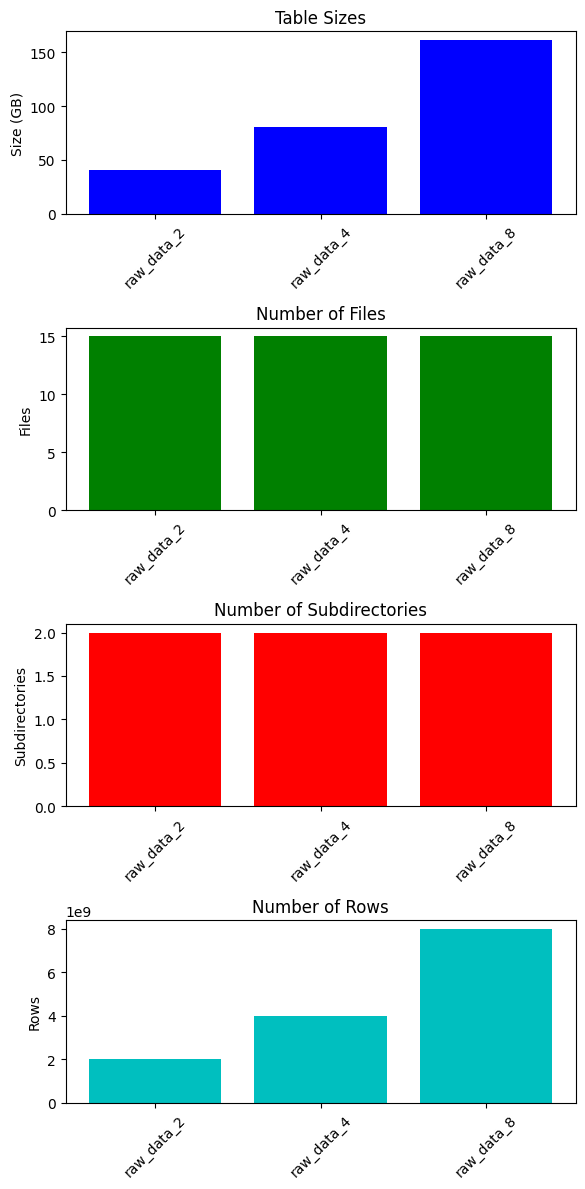

In [19]:
display_table_properties(spark, "raw_data", ['raw_data_2', 'raw_data_4', 'raw_data_8'])

In [4]:
# Create another set of tables with different file size

spark.sql(f"""
    CREATE TABLE rawdata_2 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)
spark.sql(f"""
    CREATE TABLE rawdata_4 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)
spark.sql(f"""
    CREATE TABLE rawdata_8 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

24/08/03 14:56:57 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_2` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/03 14:56:58 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/08/03 14:57:04 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_4` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/03 14:57:04 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


DataFrame[]

In [48]:
# Create another set of tables with different file size

spark.sql(f"""
    drop TABLE rawdata_2 
    """)
spark.sql(f"""
    drop TABLE rawdata_4 
    """)
spark.sql(f"""
    drop TABLE rawdata_8 
    """)

DataFrame[]

In [52]:
spark.sql(f"""
use database  zorder  """).show()

++
||
++
++



In [55]:
spark.sql(f"""
    drop TABLE zorder_eventid_table_8
    """)

DataFrame[]

In [ ]:
zorder_eventid_table_2

In [51]:
spark.sql(f"""
drop database stream cascade   """).show()

++
||
++
++



In [41]:
# Create another set of tables with different file size

spark.sql(f"""
    CREATE TABLE rawdata_2 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)
spark.sql(f"""
    CREATE TABLE rawdata_4 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)
spark.sql(f"""
    CREATE TABLE rawdata_8 (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

24/08/05 17:18:46 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_2` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/05 17:18:46 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/08/05 17:18:47 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_4` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/08/05 17:18:49 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`raw_data`.`rawdata_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


DataFrame[]

In [42]:
table_pairs = [
    ('rawdata_8', 'raw_data.raw_data_8'),
    ('rawdata_4', 'raw_data.raw_data_4'),
    ('rawdata_2', 'raw_data.raw_data_2')
]

for target_table, source_table in table_pairs:
    insert_sql = f"""
    INSERT INTO {target_table}
    SELECT * FROM {source_table}
    """
    print(f"Inserting data for table {target_table}")
    %time spark.sql(insert_sql)

Inserting data for table rawdata_8


ERROR:root:KeyboardInterrupt while sending command.           (128 + 15) / 1293]
Traceback (most recent call last):
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

Inserting data for table rawdata_4


24/08/05 18:27:41 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/08/05 18:27:41 ERROR DeltaFileFormatWriter: Aborting job 1ab98887-3525-4cf5-826b-008e9083619f.
org.apache.spark.SparkException: Job aborted due to stage failure: Master removed our application: KILLED
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(

Py4JJavaError: An error occurred while calling o460.sql.
: org.apache.spark.SparkException: Job aborted due to stage failure: Master removed our application: KILLED
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:3573)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:3573)
	at org.apache.spark.sql.delta.Snapshot.protocolMetadataAndICTReconstruction(Snapshot.scala:309)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT$lzycompute(Snapshot.scala:203)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT(Snapshot.scala:196)
	at org.apache.spark.sql.delta.Snapshot.metadata(Snapshot.scala:278)
	at org.apache.spark.sql.delta.managedcommit.CommitOwnerProvider$.getTableCommitOwner(CommitOwnerClient.scala:212)
	at org.apache.spark.sql.delta.Snapshot.initializeTableCommitOwner(Snapshot.scala:237)
	at org.apache.spark.sql.delta.Snapshot.<init>(Snapshot.scala:235)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$createSnapshot$2(SnapshotManagement.scala:634)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment(SnapshotManagement.scala:796)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment$(SnapshotManagement.scala:782)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshotFromGivenOrEquivalentLogSegment(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot(SnapshotManagement.scala:627)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot$(SnapshotManagement.scala:618)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotForLogSegmentInternal$1(SnapshotManagement.scala:1043)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal(SnapshotManagement.scala:1036)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal$(SnapshotManagement.scala:1031)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotForLogSegmentInternal(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot(SnapshotManagement.scala:1012)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot$(SnapshotManagement.scala:1003)
	at org.apache.spark.sql.delta.DeltaLog.getUpdatedSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$2(SnapshotManagement.scala:583)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog.recordFrameProfile(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$1(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly(SnapshotManagement.scala:78)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly$(SnapshotManagement.scala:75)
	at org.apache.spark.sql.delta.DeltaLog.withSnapshotLockInterruptibly(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit$(SnapshotManagement.scala:572)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotAtInit(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$init$(SnapshotManagement.scala:69)
	at org.apache.spark.sql.delta.DeltaLog.<init>(DeltaLog.scala:80)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$4(DeltaLog.scala:853)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$3(DeltaLog.scala:848)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog$.recordFrameProfile(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.$anonfun$recordDeltaOperationInternal$1(DeltaLogging.scala:136)
	at com.databricks.spark.util.DatabricksLogging.recordOperation(DatabricksLogging.scala:128)
	at com.databricks.spark.util.DatabricksLogging.recordOperation$(DatabricksLogging.scala:117)
	at org.apache.spark.sql.delta.DeltaLog$.recordOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperationInternal(DeltaLogging.scala:135)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation(DeltaLogging.scala:125)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation$(DeltaLogging.scala:115)
	at org.apache.spark.sql.delta.DeltaLog$.recordDeltaOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.DeltaLog$.createDeltaLog$1(DeltaLog.scala:847)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$5(DeltaLog.scala:866)
	at com.google.common.cache.LocalCache$LocalManualCache$1.load(LocalCache.java:4792)
	at com.google.common.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at com.google.common.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at com.google.common.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at com.google.common.cache.LocalCache$Segment.get(LocalCache.java:2257)
	at com.google.common.cache.LocalCache.get(LocalCache.java:4000)
	at com.google.common.cache.LocalCache$LocalManualCache.get(LocalCache.java:4789)
	at org.apache.spark.sql.delta.DeltaLog$.getDeltaLogFromCache$1(DeltaLog.scala:865)
	at org.apache.spark.sql.delta.DeltaLog$.apply(DeltaLog.scala:875)
	at org.apache.spark.sql.delta.DeltaLog$.forTable(DeltaLog.scala:751)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$deltaLog$1(DeltaTableV2.scala:92)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:367)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog$lzycompute(DeltaTableV2.scala:92)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog(DeltaTableV2.scala:90)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$4(DeltaTableV2.scala:145)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$1(DeltaTableV2.scala:145)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:367)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot$lzycompute(DeltaTableV2.scala:144)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot(DeltaTableV2.scala:124)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$tableSchema$2(DeltaTableV2.scala:168)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.tableSchema$lzycompute(DeltaTableV2.scala:168)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.tableSchema(DeltaTableV2.scala:166)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.schema(DeltaTableV2.scala:173)
	at org.apache.spark.sql.connector.catalog.Table.columns(Table.java:65)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.columns(DeltaTableV2.scala:58)
	at org.apache.spark.sql.execution.datasources.v2.DataSourceV2Relation$.create(DataSourceV2Relation.scala:197)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.$anonfun$createRelation$1(Analyzer.scala:1249)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.createRelation(Analyzer.scala:1221)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.$anonfun$resolveRelation$3(Analyzer.scala:1272)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.$anonfun$resolveRelation$1(Analyzer.scala:1270)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveRelations$$resolveRelation(Analyzer.scala:1262)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$14.applyOrElse(Analyzer.scala:1126)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$14.applyOrElse(Analyzer.scala:1090)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$2(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1214)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:71)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$2(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1214)
	at org.apache.spark.sql.catalyst.plans.logical.InsertIntoStatement.mapChildren(statements.scala:171)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1090)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1049)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:226)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:173)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:188)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:209)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:208)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:77)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:77)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:99)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:97)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:638)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:629)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:659)
	at sun.reflect.GeneratedMethodAccessor54.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


Inserting data for table rawdata_2


Py4JJavaError: An error occurred while calling o460.sql.
: org.sparkproject.guava.util.concurrent.UncheckedExecutionException: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.sparkproject.guava.cache.LocalCache$Segment.get(LocalCache.java:2263)
	at org.sparkproject.guava.cache.LocalCache.get(LocalCache.java:4000)
	at org.sparkproject.guava.cache.LocalCache$LocalManualCache.get(LocalCache.java:4789)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getCachedPlan(SessionCatalog.scala:209)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable.org$apache$spark$sql$execution$datasources$FindDataSourceTable$$readDataSourceTable(DataSourceStrategy.scala:248)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable$$anonfun$apply$2.applyOrElse(DataSourceStrategy.scala:281)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable$$anonfun$apply$2.applyOrElse(DataSourceStrategy.scala:278)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$2(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$1(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning(AnalysisHelper.scala:168)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning$(AnalysisHelper.scala:164)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning(AnalysisHelper.scala:99)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning$(AnalysisHelper.scala:96)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperators(AnalysisHelper.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperators$(AnalysisHelper.scala:75)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperators(LogicalPlan.scala:32)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable.apply(DataSourceStrategy.scala:278)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable.apply(DataSourceStrategy.scala:242)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:226)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:173)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:188)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:209)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:208)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:77)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:77)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:99)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:97)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:638)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:629)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:659)
	at sun.reflect.GeneratedMethodAccessor54.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.json.JsonFileFormat.buildReader(JsonFileFormat.scala:99)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:455)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:498)
	at org.apache.spark.sql.execution.FilterExec.inputRDDs(basicPhysicalOperators.scala:242)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:364)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:445)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:3573)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:3573)
	at org.apache.spark.sql.delta.Snapshot.protocolMetadataAndICTReconstruction(Snapshot.scala:309)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT$lzycompute(Snapshot.scala:203)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT(Snapshot.scala:196)
	at org.apache.spark.sql.delta.Snapshot.metadata(Snapshot.scala:278)
	at org.apache.spark.sql.delta.managedcommit.CommitOwnerProvider$.getTableCommitOwner(CommitOwnerClient.scala:212)
	at org.apache.spark.sql.delta.Snapshot.initializeTableCommitOwner(Snapshot.scala:237)
	at org.apache.spark.sql.delta.Snapshot.<init>(Snapshot.scala:235)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$createSnapshot$2(SnapshotManagement.scala:634)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment(SnapshotManagement.scala:796)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment$(SnapshotManagement.scala:782)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshotFromGivenOrEquivalentLogSegment(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot(SnapshotManagement.scala:627)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot$(SnapshotManagement.scala:618)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotForLogSegmentInternal$1(SnapshotManagement.scala:1043)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal(SnapshotManagement.scala:1036)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal$(SnapshotManagement.scala:1031)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotForLogSegmentInternal(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot(SnapshotManagement.scala:1012)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot$(SnapshotManagement.scala:1003)
	at org.apache.spark.sql.delta.DeltaLog.getUpdatedSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$2(SnapshotManagement.scala:583)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog.recordFrameProfile(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$1(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly(SnapshotManagement.scala:78)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly$(SnapshotManagement.scala:75)
	at org.apache.spark.sql.delta.DeltaLog.withSnapshotLockInterruptibly(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit$(SnapshotManagement.scala:572)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotAtInit(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$init$(SnapshotManagement.scala:69)
	at org.apache.spark.sql.delta.DeltaLog.<init>(DeltaLog.scala:80)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$4(DeltaLog.scala:853)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$3(DeltaLog.scala:848)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog$.recordFrameProfile(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.$anonfun$recordDeltaOperationInternal$1(DeltaLogging.scala:136)
	at com.databricks.spark.util.DatabricksLogging.recordOperation(DatabricksLogging.scala:128)
	at com.databricks.spark.util.DatabricksLogging.recordOperation$(DatabricksLogging.scala:117)
	at org.apache.spark.sql.delta.DeltaLog$.recordOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperationInternal(DeltaLogging.scala:135)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation(DeltaLogging.scala:125)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation$(DeltaLogging.scala:115)
	at org.apache.spark.sql.delta.DeltaLog$.recordDeltaOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.DeltaLog$.createDeltaLog$1(DeltaLog.scala:847)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$5(DeltaLog.scala:866)
	at com.google.common.cache.LocalCache$LocalManualCache$1.load(LocalCache.java:4792)
	at com.google.common.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at com.google.common.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at com.google.common.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at com.google.common.cache.LocalCache$Segment.get(LocalCache.java:2257)
	at com.google.common.cache.LocalCache.get(LocalCache.java:4000)
	at com.google.common.cache.LocalCache$LocalManualCache.get(LocalCache.java:4789)
	at org.apache.spark.sql.delta.DeltaLog$.getDeltaLogFromCache$1(DeltaLog.scala:865)
	at org.apache.spark.sql.delta.DeltaLog$.apply(DeltaLog.scala:875)
	at org.apache.spark.sql.delta.DeltaLog$.forTable(DeltaLog.scala:751)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$deltaLog$1(DeltaTableV2.scala:92)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:367)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog$lzycompute(DeltaTableV2.scala:92)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog(DeltaTableV2.scala:90)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$4(DeltaTableV2.scala:145)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$1(DeltaTableV2.scala:145)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:367)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot$lzycompute(DeltaTableV2.scala:144)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot(DeltaTableV2.scala:124)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.toBaseRelation$lzycompute(DeltaTableV2.scala:236)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.toBaseRelation(DeltaTableV2.scala:234)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.$anonfun$createRelation$5(DeltaDataSource.scala:250)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.recordFrameProfile(DeltaDataSource.scala:49)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.createRelation(DeltaDataSource.scala:209)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.execution.datasources.FindDataSourceTable.$anonfun$readDataSourceTable$1(DataSourceStrategy.scala:260)
	at org.sparkproject.guava.cache.LocalCache$LocalManualCache$1.load(LocalCache.java:4792)
	at org.sparkproject.guava.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at org.sparkproject.guava.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at org.sparkproject.guava.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at org.sparkproject.guava.cache.LocalCache$Segment.get(LocalCache.java:2257)
	... 68 more


In [ ]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/raw_data/rawdata_8",
    "hdfs://192.168.0.144:9000/datalake/raw_data/rawdata_4",
    "hdfs://192.168.0.144:9000/datalake/raw_data/rawdata_2"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()

In [11]:
def vacuum_delta_table(table_path):
    spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
    delta_table_obj = DeltaTable.forPath(spark, table_path)
    delta_table_obj.vacuum(0)

for path in table_paths:
    table_name = path.split("/")[-1]
    print(f"Vaccuum table: {table_name}")
    %time vacuum_delta_table(path)

Vaccuum table: rawdata_8


Deleted 57 files and directories in a total of 1 directories.
CPU times: user 41.8 ms, sys: 104 ms, total: 146 ms
Wall time: 37.2 s


In [43]:
display_table_properties(spark, "raw_data", ['rawdata_2', 'rawdata_4', 'rawdata_8'])

Py4JJavaError: An error occurred while calling o460.sql.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.json.JsonFileFormat.buildReader(JsonFileFormat.scala:99)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:455)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:498)
	at org.apache.spark.sql.execution.FilterExec.inputRDDs(basicPhysicalOperators.scala:242)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:364)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:445)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:3573)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:3573)
	at org.apache.spark.sql.delta.Snapshot.protocolMetadataAndICTReconstruction(Snapshot.scala:309)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT$lzycompute(Snapshot.scala:203)
	at org.apache.spark.sql.delta.Snapshot._reconstructedProtocolMetadataAndICT(Snapshot.scala:196)
	at org.apache.spark.sql.delta.Snapshot.metadata(Snapshot.scala:278)
	at org.apache.spark.sql.delta.managedcommit.CommitOwnerProvider$.getTableCommitOwner(CommitOwnerClient.scala:212)
	at org.apache.spark.sql.delta.Snapshot.initializeTableCommitOwner(Snapshot.scala:237)
	at org.apache.spark.sql.delta.Snapshot.<init>(Snapshot.scala:235)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$createSnapshot$2(SnapshotManagement.scala:634)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment(SnapshotManagement.scala:796)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment$(SnapshotManagement.scala:782)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshotFromGivenOrEquivalentLogSegment(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot(SnapshotManagement.scala:627)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot$(SnapshotManagement.scala:618)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotForLogSegmentInternal$1(SnapshotManagement.scala:1043)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal(SnapshotManagement.scala:1036)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotForLogSegmentInternal$(SnapshotManagement.scala:1031)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotForLogSegmentInternal(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot(SnapshotManagement.scala:1012)
	at org.apache.spark.sql.delta.SnapshotManagement.getUpdatedSnapshot$(SnapshotManagement.scala:1003)
	at org.apache.spark.sql.delta.DeltaLog.getUpdatedSnapshot(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$2(SnapshotManagement.scala:583)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog.recordFrameProfile(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$1(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly(SnapshotManagement.scala:78)
	at org.apache.spark.sql.delta.SnapshotManagement.withSnapshotLockInterruptibly$(SnapshotManagement.scala:75)
	at org.apache.spark.sql.delta.DeltaLog.withSnapshotLockInterruptibly(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit(SnapshotManagement.scala:573)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit$(SnapshotManagement.scala:572)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotAtInit(DeltaLog.scala:74)
	at org.apache.spark.sql.delta.SnapshotManagement.$init$(SnapshotManagement.scala:69)
	at org.apache.spark.sql.delta.DeltaLog.<init>(DeltaLog.scala:80)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$4(DeltaLog.scala:853)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$3(DeltaLog.scala:848)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:168)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:166)
	at org.apache.spark.sql.delta.DeltaLog$.recordFrameProfile(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.$anonfun$recordDeltaOperationInternal$1(DeltaLogging.scala:136)
	at com.databricks.spark.util.DatabricksLogging.recordOperation(DatabricksLogging.scala:128)
	at com.databricks.spark.util.DatabricksLogging.recordOperation$(DatabricksLogging.scala:117)
	at org.apache.spark.sql.delta.DeltaLog$.recordOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperationInternal(DeltaLogging.scala:135)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation(DeltaLogging.scala:125)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation$(DeltaLogging.scala:115)
	at org.apache.spark.sql.delta.DeltaLog$.recordDeltaOperation(DeltaLog.scala:651)
	at org.apache.spark.sql.delta.DeltaLog$.createDeltaLog$1(DeltaLog.scala:847)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$5(DeltaLog.scala:866)
	at com.google.common.cache.LocalCache$LocalManualCache$1.load(LocalCache.java:4792)
	at com.google.common.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at com.google.common.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at com.google.common.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at com.google.common.cache.LocalCache$Segment.get(LocalCache.java:2257)
	at com.google.common.cache.LocalCache.get(LocalCache.java:4000)
	at com.google.common.cache.LocalCache$LocalManualCache.get(LocalCache.java:4789)
	at org.apache.spark.sql.delta.DeltaLog$.getDeltaLogFromCache$1(DeltaLog.scala:865)
	at org.apache.spark.sql.delta.DeltaLog$.apply(DeltaLog.scala:875)
	at org.apache.spark.sql.delta.DeltaLog$.forTable(DeltaLog.scala:751)
	at org.apache.spark.sql.delta.commands.DescribeDeltaDetailCommand.run(DescribeDeltaDetailsCommand.scala:93)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:220)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:100)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:97)
	at org.apache.spark.sql.SparkSession.$anonfun$sql$1(SparkSession.scala:638)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:629)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:659)
	at sun.reflect.GeneratedMethodAccessor54.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import

java_import(spark._jvm, "org.apache.hadoop.fs.FileSystem")
java_import(spark._jvm, "org.apache.hadoop.fs.Path")

def list_hdfs_directory(hdfs_path, level=0):
    hadoop_conf = spark._jsc.hadoopConfiguration()
    fs = spark._jvm.FileSystem.get(hadoop_conf)
    path = spark._jvm.Path(hdfs_path)
    
    if level == 0:
        print(f"Listing contents of: {hdfs_path}")
    
    status = fs.listStatus(path)
    
    for file_status in status:
        file_path = file_status.getPath()
        is_dir = file_status.isDirectory()
        size = file_status.getLen() if not is_dir else 0
        indent = ' ' * (level * 2)
        if is_dir:
            print(f"{indent}- {file_path.getName()}/")
            list_hdfs_directory(file_path.toString(), level + 1)
        else:
            size_mb = size / (1024 * 1024)
            print(f"{indent}- {file_path.getName()} ({size_mb:.2f} MB)")

In [20]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


num_executions = 2


def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

def get_average_execution_times(query_template, num_executions, tables):
    execution_times = {table: [] for table in tables}
    for table in tables:
        for _ in range(num_executions):
            query = query_template.format(table=table)
            try:
                execution_time = measure_execution_time(query)
                print(f"{table}: {execution_time} seconds")
                execution_times[table].append(execution_time)
            except Exception as e:
                print(f"Error for table {table}: {e}")
    average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
    return average_times

query1_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    COUNT({table}.event_id) AS event_count
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country;
"""

query2_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    avg({table}.value) AS total_value
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country
ORDER BY
    total_value DESC;
"""

In [21]:
tables = [
    'raw_data.raw_data_8',
    'raw_data.raw_data_4',
    'raw_data.raw_data_2'
]

average_times_query1_2gb = get_average_execution_times(query1_template, num_executions, tables)

tables = [
    'raw_data.rawdata_8',
    'raw_data.rawdata_4',
    'raw_data.rawdata_2'
]

average_times_query1_1gb = get_average_execution_times(query1_template, num_executions, tables)

+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product G| San Antonio|   TX|    USA|     129012|
|   Product D|     Houston|   TX|    USA|     129594|
|   Product H|   San Diego|   CA|    USA|     129806|
|   Product B| Los Angeles|   CA|    USA|     129185|
|   Product F|Philadelphia|   PA|    USA|     129374|
|   Product C|     Chicago|   IL|    USA|     129489|
|   Product J|    San Jose|   CA|    USA|     129137|
|   Product E|     Phoenix|   AZ|    USA|     129858|
|   Product I|      Dallas|   TX|    USA|     129584|
|   Product A|    New York|   NY|    USA|     129076|
+------------+------------+-----+-------+-----------+

raw_data.raw_data_8: 2633.015395641327 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product G| San Antonio|   TX|    USA|     129012|
|   Product D|     Houston|   TX|    USA|     129594|
|   Product H|   San Diego|   CA|    USA|     129806|
|   Product B| Los Angeles|   CA|    USA|     129185|
|   Product F|Philadelphia|   PA|    USA|     129374|
|   Product C|     Chicago|   IL|    USA|     129489|
|   Product J|    San Jose|   CA|    USA|     129137|
|   Product E|     Phoenix|   AZ|    USA|     129858|
|   Product I|      Dallas|   TX|    USA|     129584|
|   Product A|    New York|   NY|    USA|     129076|
+------------+------------+-----+-------+-----------+

raw_data.raw_data_8: 3155.9342246055603 seconds


+------------+------------+-----+-------+-----------+
|product_name|        city|state|country|event_count|
+------------+------------+-----+-------+-----------+
|   Product G| San Antonio|   TX|    USA|      64622|
|   Product D|     Houston|   TX|    USA|      64944|
|   Product H|   San Diego|   CA|    USA|      64856|
|   Product B| Los Angeles|   CA|    USA|      64775|
|   Product F|Philadelphia|   PA|    USA|      64727|
|   Product C|     Chicago|   IL|    USA|      64872|
|   Product J|    San Jose|   CA|    USA|      64522|
|   Product E|     Phoenix|   AZ|    USA|      64419|
|   Product I|      Dallas|   TX|    USA|      64561|
|   Product A|    New York|   NY|    USA|      65019|
+------------+------------+-----+-------+-----------+

raw_data.raw_data_4: 1574.626448392868 seconds


ERROR:root:KeyboardInterrupt while sending command.===>        (543 + 15) / 647]
Traceback (most recent call last):
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
print(average_times_query1_2gb)
print(average_times_query1_1gb)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Partitioning"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Partitioning"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query {query_num})')
    plt.xticks(rotation=0)
    
    plt.ylim(0, 110)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12})  

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01), 
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'raw_table_performance_{query_num}.png', dpi=500)
    plt.show()

In [ ]:
plot_comparison(average_times_query1_2gb, average_times_query1_1gb, 1)

In [27]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


num_executions = 1


def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

def get_average_execution_times(query_template, num_executions, tables):
    execution_times = {table: [] for table in tables}
    for table in tables:
        for _ in range(num_executions):
            query = query_template.format(table=table)
            try:
                execution_time = measure_execution_time(query)
                print(f"{table}: {execution_time} seconds")
                execution_times[table].append(execution_time)
            except Exception as e:
                print(f"Error for table {table}: {e}")
    average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
    return average_times

query1_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    COUNT({table}.event_id) AS event_count
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country;
"""

query2_template = """
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    avg({table}.value) AS total_value
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country
ORDER BY
    total_value DESC;
"""

In [28]:
tables = [
    'raw_data.raw_data_8',
    'raw_data.raw_data_4',
    'raw_data.raw_data_2'
]

average_times_query1_2gb = get_average_execution_times(query2_template, num_executions, tables)

tables = [
    'raw_data.rawdata_8',
    'raw_data.rawdata_4',
    'raw_data.rawdata_2'
]

#average_times_query1_1gb = get_average_execution_times(query2_template, num_executions, tables)

ERROR:root:KeyboardInterrupt while sending command.            (20 + 15) / 1293]
Traceback (most recent call last):
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
print(average_times_query1_2gb)
print(average_times_query1_1gb)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Partitioning"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Partitioning"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query {query_num})')
    plt.xticks(rotation=0)
    
    plt.ylim(0, 110)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12})  

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01), 
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'raw_table_performance_{query_num}.png', dpi=500)
    plt.show()

In [ ]:
plot_comparison(average_times_query1_2gb, average_times_query1_1gb, 1)

In [37]:
spark.sql("""
SELECT
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country,
    COUNT({table}.event_id) AS event_count
FROM
    {table}
JOIN
    raw_data.product_dim ON {table}.product_id = raw_data.product_dim.product_id
JOIN
    raw_data.location_dim ON {table}.location_id = raw_data.location_dim.location_id
WHERE
    {table}.event_id BETWEEN 459999 AND 999999  
    AND {table}.actor_id IN (5001, 5002, 5003)  
GROUP BY
    raw_data.product_dim.product_name,
    raw_data.location_dim.city,
    raw_data.location_dim.state,
    raw_data.location_dim.country
ORDER BY
    total_value DESC;
""").show()

+------------------+
|       total_value|
+------------------+
|0.4999880171256666|
+------------------+



In [39]:
spark.sql("""
SELECT

    avg(rawdata_2.value) AS total_value
FROM
    rawdata_2
""").show()

+-------------------+
|        total_value|
+-------------------+
|0.49998801712566676|
+-------------------+

